# Now you "C" me DataScience Final Project 
link to video: https://youtu.be/lhodcPtmywc

# RNA and hMeDIP Clustering and Data Exploration

## Information obtained from data cleaning

In the three previous notebooks I have cleaned up all of the data and created dataframes that contain info about all of the expressed genes. There is one dataframe for each data set (Human ARPE-19 cells treated with vitamin C, Rat Schwann cells treated with vitamin C, and Rat Schwann cells treated with cAMP). The columns (not necessarily in this order) are as follows: 

1. Ensembl ID: this is just the ID for each gene, will be used as the index
2. Change: meaning the change in transcription in response to either vitamin C or cAMP, this will be the label
3. Name: This is the gene name. I kept these so that we can look at the clusters later, but this will not be included in the analysis.
4. Biotype: Most of these are protein coding, so this will be changed to a binary classification of either protein coding or not protein coding
5. Chromosome: Should not be a confounding variable, but I thought I should include it for just in case.
6. Length: Entire transcript length, from transcription start site (TSS) to transcription termination site (TTS)
7. Exonic Length: Length of the coding transcript, exons only
8. TSS_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's TSS
9. Downstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
10. Gene_Body_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
11. Upstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
12. TSS_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's TSS
13. Downstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
14. Gene_Body_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
15. Upstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
16. TSS_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's TSS
17. Downstream_Promoter_Upregulated: Number of peaks that increae in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
18. Gene_Body_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
19. Upstream_Promoter_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)




## This notebook will contain classification steps for these datasets

For this notebook, I will include information about the machine learning classification. I plan to split one dataset (ARPE) into test and train sets to see how well I can classify the test genes. Whichever one works best will be trained on all of the genes from the ARPE dataset and then used to classify the genes in the schwann cell dataset. I predict that this will not be particularly successful on predicting changes in the Schwann cells, simply because it is another cell type and another species (human vs. rat). The cAMP dataset is also likely to not have great prediction because it is treated with cAMP, which affects three transcription factors (CREM, CREM, ATF1). 

In [1]:
import os
import pandas as pd
import numpy as np


from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

In [2]:
cleaned_data_path = "Output_Tables_and_Results/"
output_path = "Classification_Output/"

In [3]:
os.listdir("Output_Tables_and_Results/")


['ARPE_Intermediate_Files',
 'SC_VitC_Combined_Cleaned_Data.csv',
 'SC_cAMP_Combined_Cleaned_Data.pkl',
 '.DS_Store',
 'ARPE_Combined_Cleaned_Data.csv',
 'ARPE_Combined_Cleaned_Data.pkl',
 'SC-VitC_Intermediate_Files',
 'SC-cAMP_Intermediate_Files',
 'SC_cAMP_Combined_Cleaned_Data.csv',
 'SC_VitC_Combined_Cleaned_Data.pkl']

In [4]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")



In [5]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated
Ensembl_ID,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


The first step is going to be to split the data into numpy arrays. Unfortunately, I am also going to have to create dummy variables for the categorical variables that I want to include. I also need to change the "Change" to numbers. I think I will use 0 for downregulated, 1 for nondifferential and 2 for upregulated. Biotype will be split into "protein_coding" vs everything else. For chromosomes, I am just going to split it into nuclear chromosomes vs mitochondrial chromosome and patches.  


In [6]:
ARPE_cleaned_dataset["Chr"].unique()

array(['X', '20', '1', '6', '7', '12', '11', '4', '17', '2', '16', '3',
       '19', '9', '13', '14', '8', 'Y', '5', '10', '22', '18', '15', '21',
       'MT', 'KI270711.1', 'GL000219.1', 'KI270713.1', 'GL000195.1'],
      dtype=object)

In [7]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

ARPE_cleaned_dataset["Numeric_Change"] = ARPE_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

ARPE_cleaned_dataset["Numeric_Biotype"] = ARPE_cleaned_dataset["Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

ARPE_cleaned_dataset["Numeric_Chr"] = ARPE_cleaned_dataset["Chr"].apply(get_chromosome)

In [8]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,...,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1,1,0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,1,0


In [9]:
ARPE_cleaned_dataset.describe()

,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr
count,1.459900e+04,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000
mean,6.280085e+04,3476.985684,0.002671,0.010823,0.136105,0.012604,0.049387,0.205425,1.644702,0.224741,0.110419,0.342147,1.900267,0.330708,1.126379,0.769094,0.002055
std,1.150453e+05,2869.609131,0.051618,0.104787,0.558936,0.111560,0.234009,0.495142,3.781105,0.530842,0.371804,0.728718,4.845714,0.730941,0.551861,0.421427,0.045286
min,4.800000e+01,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.014000e+03,1460.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.629700e+04,2794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,6.702300e+04,4676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000
max,2.092292e+06,34526.000000,1.000000,2.000000,15.000000,1.000000,4.000000,7.000000,66.000000,8.000000,6.000000,11.000000,106.000000,11.000000,2.000000,1.000000,1.000000


In [10]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr'], dtype=object)

In [11]:
ARPE_X = np.array(ARPE_cleaned_dataset[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])\

ARPE_y = np.array(ARPE_cleaned_dataset[["Numeric_Change"]])

In [12]:
scaled_ARPE_X = scale(ARPE_X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 

In [14]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2919
2919
11680
11680


Now I am going to try to figure out a good value for C in using an SVM. I recall from the previous ones we run, a bad value of C doesn't decrease your accuracy that much. I am going to only use the training data because it takes too long to run with all ~15,000 genes. I will run a test-train split and a cross-val once I find a good value of C. 

In [15]:
## It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.
## I have put pound signs through a few parts and saved the results in csv format so that if you run the whole notebook
## with the restart and run all option, it will not take more than half an hour to complete. 

# Cs = np.arange(1,502,5)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_SVM_C_values.csv")

In [16]:
ARPE_SVM_Cs = pd.read_csv(output_path+"ARPE_SVM_C_values.csv", index_col = 0)
ARPE_SVM_Cs.head()

,C_value,Accuracy
0,1,0.689622
1,6,0.684481
2,11,0.680374
3,16,0.677635
4,21,0.674901


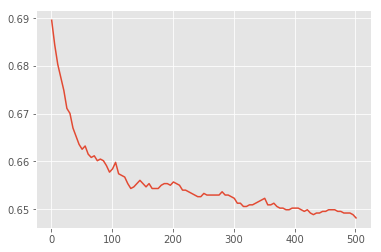

In [17]:

plt.plot(ARPE_SVM_Cs[["C_value"]], ARPE_SVM_Cs[["Accuracy"]])
plt.show()

It looks like the low numbers give the highest accuracy. I am going to repeat this step with values of C between 0 and 5.

In [18]:
## It looks like the low numbers are the best ones. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.6920195443108341 for C = 0.7


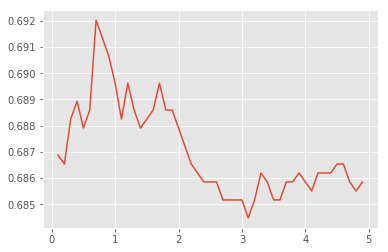

In [19]:
ARPE_SVM_Cs_concentrated = pd.read_csv(output_path+"ARPE_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(ARPE_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( ARPE_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(ARPE_SVM_Cs_concentrated[["C_value"]], ARPE_SVM_Cs_concentrated[["Accuracy"]])
plt.show()        

Even though I did a cross validation using only 1/5 of the genes, I think this value of C should be ok. This is the first time I have seen a value of C below 1 be the highest. The maximum that I got was 0.7.

In [20]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.6842465753424658

Confusion Matrix:
[[   0 1121   30]
 [   0 7726  189]
 [   0 2348  266]]


In [21]:

model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X, y = ARPE_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())



5-fold cross validation Accuracy =  0.6885420679937685


In [22]:
ARPE_SVM_accuracy_scores = ( scores.mean(), ARPE_test_train_accuracy)
ARPE_SVM_accuracy_scores

(0.6885420679937685, 0.6842465753424658)

From the confusion matrix, this is total crap. It didn't predict that a single thing was downregulated. Looking at the test data, we had 67.77% nondifferential, 9.85% downregulated and 22.38% upregulated. Bayesian statistics would put guessing any random one correctly at 51.9%. Going up to ~69% accuracy is an improvement, but we have a 0% accuracy of predicting downregulated genes. I think we can only do predictions on ones that have at least one 5hmC peak. If they are all 0, they are probably predicted as nondifferential.

I looked at the data, and it looks like a large proportion of the genes have 0 peaks in the promoter and either 0 or 1 peak in the gene body. I think I am going to filter this for genes that have either 1 peaks in the promoter or 2+ peaks in the gene body (or both). 

In [23]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,...,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1,1,0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,1,0


In [24]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr'], dtype=object)

In [25]:
ARPE_cleaned_dataset["Gene_Body_Counts"] = (ARPE_cleaned_dataset["Gene_Body_Downregulated"]+ 
                                            ARPE_cleaned_dataset["Gene_Body_Nondifferential"] + ARPE_cleaned_dataset["Gene_Body_Upregulated"])

ARPE_cleaned_dataset["Promoter_Counts"] = (ARPE_cleaned_dataset["TSS_Downregulated"]+ ARPE_cleaned_dataset["Downstream_Promoter_Downregulated"]+ 
                                           ARPE_cleaned_dataset["Upstream_Promoter_Downregulated"]+ ARPE_cleaned_dataset["TSS_Nondifferential"]+ 
                                           ARPE_cleaned_dataset["Downstream_Promoter_Nondifferential"]+ ARPE_cleaned_dataset["Upstream_Promoter_Nondifferential"]+ 
                                           ARPE_cleaned_dataset["TSS_Upregulated"]+ ARPE_cleaned_dataset["Downstream_Promoter_Upregulated"]+ 
                                           ARPE_cleaned_dataset["Upstream_Promoter_Upregulated"])



In [26]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,...,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr,Gene_Body_Counts,Promoter_Counts
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0,1.0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1,1,0,1.0,0.0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1,1,0,2.0,0.0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1,1,0,6.0,0.0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,1,0,1.0,1.0


In [27]:
def get_keep_or_discard(gene, promoter):
    if gene > 1:
        return 1 #"Keep"
    else:
        if promoter > 0:
            return 1 #"Keep"
        else:
            return 0 #"Discard"

ARPE_cleaned_dataset["Discard_column"] = ARPE_cleaned_dataset["Gene_Body_Counts"].combine(
    ARPE_cleaned_dataset["Promoter_Counts"], func=get_keep_or_discard)
    


In [28]:
ARPE_cleaned_dataset.head()
# Yay! It worked. Now to subset it.

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,...,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr,Gene_Body_Counts,Promoter_Counts,Discard_column
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0.0,1.0,1.0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1,1,0,1.0,0.0,0.0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1,1,0,2.0,0.0,1.0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1,1,0,6.0,0.0,1.0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,1,0,1.0,1.0,1.0


In [29]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',
       'Gene_Body_Counts', 'Promoter_Counts', 'Discard_column'],
      dtype=object)

In [30]:
ARPE_genes_with_peaks = ARPE_cleaned_dataset[ARPE_cleaned_dataset["Discard_column"]== 1][['Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',]]

In [31]:
ARPE_X = np.array(ARPE_genes_with_peaks[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y = np.array(ARPE_genes_with_peaks[["Numeric_Change"]])

In [32]:
scaled_ARPE_X = scale(ARPE_X)
X_train, X_test, y_train, y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1940
1940
7763
7763


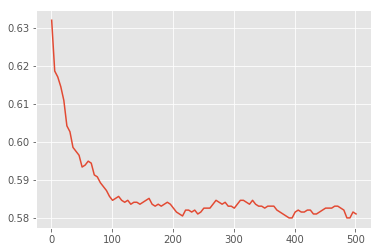

In [33]:
# It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.


Cs = np.arange(1,502,5)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
    scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()
ARPE_with_peaks_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
ARPE_with_peaks_SVM_Cs.to_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values.csv")



In [34]:
ARPE_with_peaks_SVM_Cs = pd.read_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values.csv", index_col = 0)
ARPE_with_peaks_SVM_Cs.head()

,C_value,Accuracy
0,1,0.631952
1,6,0.618579
2,11,0.617026
3,16,0.614447
4,21,0.610839


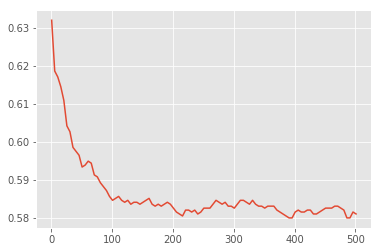

In [35]:
plt.plot(ARPE_with_peaks_SVM_Cs[["C_value"]], ARPE_with_peaks_SVM_Cs[["Accuracy"]])
plt.show()

In [36]:
# # It looks like the low numbers are the best ones again. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.631433396671061 for C = 0.7


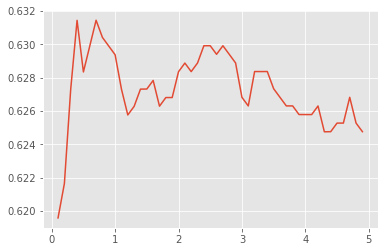

In [37]:
ARPE_with_peaks_SVM_Cs_concentrated = pd.read_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(ARPE_with_peaks_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( ARPE_with_peaks_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(ARPE_with_peaks_SVM_Cs_concentrated[["C_value"]], ARPE_with_peaks_SVM_Cs_concentrated[["Accuracy"]])
plt.show()        

Now I am going to see how it performs after removing the ones that have very few 5hmC peaks.

In [38]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.6368671905191292

Confusion Matrix:
[[   0  616   57]
 [   0 4540  311]
 [   0 1835  404]]


In [39]:
model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X, y = ARPE_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())



5-fold cross validation Accuracy =  0.6426902686747097


Well, this has even lower accuracy and still doesn't get a single one of the downregulated genes correct. I am going to try making it even more stringent (require 5 peaks in gene body) and see what happens. 

In [40]:
def get_keep_or_discard(gene, promoter):
    if gene > 5:
        return 1 #"Keep"
    else:
        if promoter > 1:
            return 1 #"Keep"
        else:
            return 0 #"Discard"

ARPE_cleaned_dataset["Try3_column"] = ARPE_cleaned_dataset["Gene_Body_Counts"].combine(
    ARPE_cleaned_dataset["Promoter_Counts"], func=get_keep_or_discard)
    


In [41]:
ARPE_try3 = ARPE_cleaned_dataset[ARPE_cleaned_dataset["Try3_column"]== 1][['Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',]]

In [42]:
ARPE_X3 = np.array(ARPE_try3[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y3 = np.array(ARPE_try3[["Numeric_Change"]])

In [43]:
scaled_ARPE_X3 = scale(ARPE_X3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(scaled_ARPE_X3, ARPE_y3, random_state=1, test_size=0.5) 
print(len(X_train3))
print(len(y_train3))
print(len(X_test3))
print(len(y_test3))

2816
2816
2816
2816


In [44]:
model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train3, y_train3.ravel())

Y_pred = model_svm.predict(X_test3)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test3.ravel(), y_pred = Y_pred)
print('Test on 50%, train on 50% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test3.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 50%, train on 50% Accuracy =  0.5862926136363636

Confusion Matrix:
[[   0  189   31]
 [   0 1400  165]
 [   0  780  251]]


In [45]:
model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X3, y = ARPE_y3.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())

5-fold cross validation Accuracy =  0.5861197494005854


Well, this was not very successful. I am not surprised that the accuracy wasn't that high, but the fact that I can't get it to predict ANYTHING as downregulated is a little intriguing. I am going to try to do this again with the Schwann Cell cAMP dataset because it has roughly 1/3 of the genes up, 1/3 down and 1/3 nondifferential. 

In [46]:
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Gene_ID,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

SC_cAMP_cleaned_dataset["Numeric_Change"] = SC_cAMP_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

SC_cAMP_cleaned_dataset["Numeric_Biotype"] = SC_cAMP_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

SC_cAMP_cleaned_dataset["Numeric_Chr"] = SC_cAMP_cleaned_dataset["Chr"].apply(get_chromosome)

In [48]:
SC_cAMP_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,...,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Numeric_Change,Numeric_Biotype,Numeric_Chr
Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0


In [49]:
SC_cAMP_X = np.array(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_cAMP_y = np.array(SC_cAMP_cleaned_dataset[["Numeric_Change"]])

In [50]:
scaled_cAMP_X = scale(SC_cAMP_X)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(scaled_cAMP_X, SC_cAMP_y, random_state=1, test_size=0.8) 

In [52]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2433
2433
9732
9732


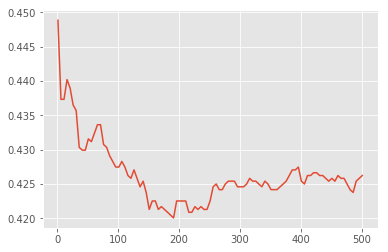

In [53]:
##It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.


Cs = np.arange(1,502,5)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
    scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()
SC_cAMP_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_SVM_Cs.to_csv(output_path+"SC_cAMP_SVM_C_values.csv")

In [54]:
SC_cAMP_SVM_Cs = pd.read_csv(output_path+"SC_cAMP_SVM_C_values.csv", index_col = 0)
SC_cAMP_SVM_Cs.head()

,C_value,Accuracy
0,1,0.448836
1,6,0.437321
2,11,0.437326
3,16,0.440200
4,21,0.438970


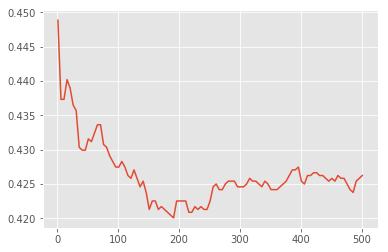

In [55]:
plt.plot(SC_cAMP_SVM_Cs[["C_value"]], SC_cAMP_SVM_Cs[["Accuracy"]])
plt.show()

It looks like a low value of C is still the best for the cAMP dataset too. 

In [56]:
# # It looks like the low numbers are the best ones. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"SC_cAMP_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.4508983913964855 for C = 0.4


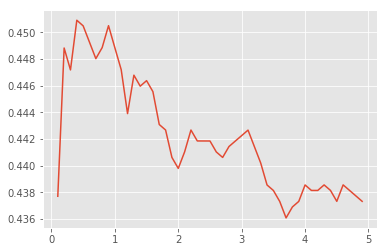

In [57]:
SC_cAMP_SVM_Cs_concentrated = pd.read_csv(output_path+"SC_cAMP_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(SC_cAMP_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( SC_cAMP_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_SVM_Cs_concentrated[["C_value"]], SC_cAMP_SVM_Cs_concentrated[["Accuracy"]])
plt.show()  

In [58]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

SC_cAMP_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_test_train_accuracy)


SC_cAMP_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.44040279490341144

Confusion Matrix:
[[1378  333 1387]
 [ 762  505 1879]
 [ 783  302 2403]]


In [59]:
model_numbers = svm.SVC(kernel='rbf', C = 0.4, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())


5-fold cross validation Accuracy =  0.4446420559390667


In [60]:
SC_cAMP_SVM_accuracy_scores = ( scores.mean(), SC_cAMP_test_train_accuracy)
SC_cAMP_SVM_accuracy_scores

(0.4446420559390667, 0.44040279490341144)

This time the accuracy is lower, but the naive baysean model would predict lower too. The theoretical 33.43% that would be achieved by chance is increased to 44% by the SVM. I am pleased that at least it gets many correct from each category, but the accuracy is still really quite low.

I am moving on to the K-Nearest-Neighbors for this dataset. The first step will be to determine a good value for K to use. I have copied code and left the variable as Cs, but it is really Ks. 

In [61]:
# #First, finding a good value of N to use

# Cs = range(1,201,2)
# Accuracies = np.zeros(100)
# for i in Cs: 
#     model_numbers = KNeighborsClassifier(n_neighbors=i)
#     scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[int((i-1)/2)]  = scores.mean()
        
# SC_cAMP_KNN_Ns = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# SC_cAMP_KNN_Ns.to_csv(output_path+"SC_cAMP_KNN_Ns.csv")

# plt.plot(Cs,Accuracies)
# plt.show()

Maximum Accuracy is: 0.4400389889587145 for C = 81


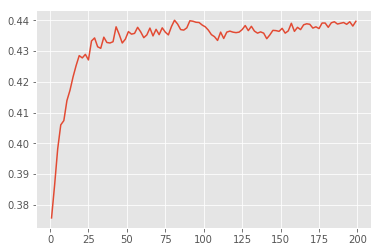

In [62]:
SC_cAMP_KNN_Ns = pd.read_csv(output_path+"SC_cAMP_KNN_Ns.csv", index_col = 0)

max_accuracies = max(SC_cAMP_KNN_Ns["Accuracy"])
for i,num in enumerate( SC_cAMP_KNN_Ns["Accuracy"]):
    if num == max_accuracies:
        max_c = i*2+1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_KNN_Ns[["C_value"]], SC_cAMP_KNN_Ns[["Accuracy"]])
plt.show() 

In [63]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())

5-fold cross validation Accuracy =  0.4446420559390667


In [64]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(X_train, y_train.ravel())

Y_pred = model_KNN.predict(X_test)

SC_cAMP_KNN_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_KNN_accuracy)


SC_cAMP_KNN_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_KNN_confusion)

Test on 80%, train on 20% Accuracy =  0.43680641183723795

Confusion Matrix:
[[1347  589 1162]
 [ 763  866 1517]
 [ 804  646 2038]]


In [65]:
SC_cAMP_KNN_accuracy_scores = ( scores.mean(), SC_cAMP_KNN_accuracy)
SC_cAMP_KNN_accuracy_scores

(0.4446420559390667, 0.43680641183723795)

I got almost the exact same accuracy for the KNN as I got for SVM. Although it isn't extremely accurate, it is better than drawing decisions out of a bag. 

Now I am going to try this with the decision tree and see how this works out. The first step is going to be to determine the max depth and the min_samples_split values that give the most accurate results. 

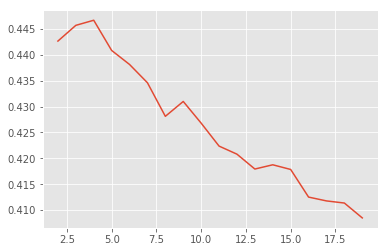

In [66]:
Cs = range(2,20,1)
Accuracies = np.zeros(len(Cs))
for i,C in enumerate(Cs): 
    model_numbers = tree.DecisionTreeClassifier(min_samples_split=15, max_depth=C)
    scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()

SC_cAMP_DT_depth = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_DT_depth.to_csv(output_path+"SC_cAMP_D_Tree_depths.csv")
        
plt.plot(Cs,Accuracies)
plt.show()

Maximum Accuracy is: 0.4466997338726301 for Depth = 4


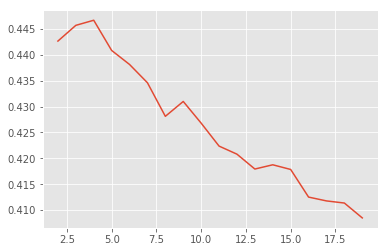

In [67]:
SC_cAMP_DT_depth = pd.read_csv(output_path+"SC_cAMP_D_Tree_depths.csv", index_col = 0)

max_accuracies = max(SC_cAMP_DT_depth["Accuracy"])
for i,num in enumerate( SC_cAMP_DT_depth["Accuracy"]):
    if num == max_accuracies:
        max_c = i+2
        print ("Maximum Accuracy is:", max_accuracies, "for Depth =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_DT_depth[["C_value"]], SC_cAMP_DT_depth[["Accuracy"]])
plt.show() 

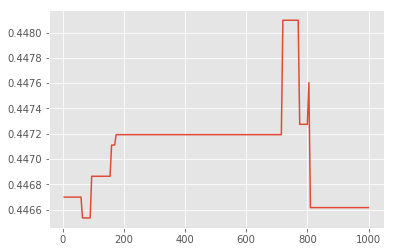

In [68]:
Cs = range(5,1001,5)
Accuracies = np.zeros(len(Cs))
for i,C in enumerate(Cs): 
    model_numbers = tree.DecisionTreeClassifier(min_samples_split=C, max_depth=4)
    scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()

SC_cAMP_DT_min_split = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_DT_min_split.to_csv(output_path+"SC_cAMP_D_Tree_min_split.csv")

plt.plot(Cs,Accuracies)
plt.show()

Maximum Accuracy is: 0.4480968817340668 for Depth = 720


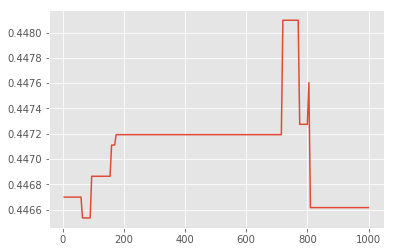

In [69]:
SC_cAMP_DT_min_split = pd.read_csv(output_path+"SC_cAMP_D_Tree_min_split.csv", index_col = 0)

max_accuracies = max(SC_cAMP_DT_min_split["Accuracy"])
for i,num in enumerate( SC_cAMP_DT_min_split["Accuracy"]):
    if num == max_accuracies:
        max_c = i*5+5
        print ("Maximum Accuracy is:", max_accuracies, "for Depth =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_DT_min_split[["C_value"]], SC_cAMP_DT_min_split[["Accuracy"]])
plt.show() 

Now I have a max depth of 4 and a min samples split value of 720. That seems shallow and like an awful lot of samples for a minimum split, but that is what the runs above have shown. 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(scaled_cAMP_X, SC_cAMP_y.ravel(), random_state=1, test_size=0.8) 
decisionTree = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 720)
decisionTree = decisionTree.fit(X_train, y_train )
y_pred_train = decisionTree.predict(X_train)
# predict with the training data
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.4603370324702014
Accuracy on test data =  0.4394780106863954


In [71]:
## This is trying the same thing, just with data that isn't scaled. 

X_train, X_test, y_train, y_test = train_test_split(SC_cAMP_X, SC_cAMP_y.ravel(), random_state=1, test_size=0.8) 
decisionTree = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 720)
decisionTree = decisionTree.fit(X_train, y_train )
y_pred_train = decisionTree.predict(X_train)
# predict with the training data
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.4603370324702014
Accuracy on test data =  0.4394780106863954


In [72]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Downregulated", "Nondifferential", "Upregulated"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = output_path+"SC_cAMP_Decision_Tree.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

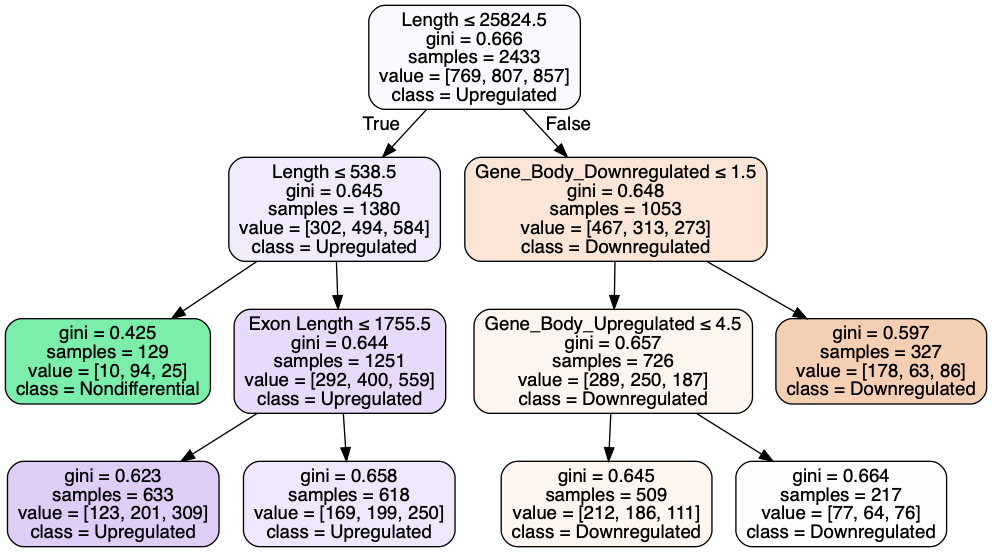

In [73]:
#used_features = list(all_of_the_columns.iloc[:,2:-1])
used_features = list(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']].columns.values)


renderTree(decisionTree, used_features)

In [74]:
print(SC_cAMP_SVM_accuracy_scores)
print(SC_cAMP_KNN_accuracy_scores)

(0.4446420559390667, 0.44040279490341144)
(0.4446420559390667, 0.43680641183723795)


Well, the results are in for the SC cAMP dataset. If I had used a naive Bayes model, I would have achieved 33.43%. Using SVM, I got 44.46% using the 5-fold cross validation and 44.04% accuracy on the one time test-train split using 80% for testing. Using KNN, I got 43.97% using the 5-fold cross validation and 43.68% accuracy on the one time test-train split using 80% for testing. Using the decision tree I got 46.03% accuracy on the training data and 43.95% accuracy on the test data. I am quite impressed that all three models gave me almost the exact same accuracy. Now that I have determined good parameters to use, I would like to see how a model trained on the SC cAMP dataset performs when tested on the other two datasets. I will try to run it back the other direction as well. 


In [75]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")


In [76]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

ARPE_cleaned_dataset["Numeric_Change"] = ARPE_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

ARPE_cleaned_dataset["Numeric_Biotype"] = ARPE_cleaned_dataset["Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

ARPE_cleaned_dataset["Numeric_Chr"] = ARPE_cleaned_dataset["Chr"].apply(get_chromosome)

In [77]:
ARPE_X = np.array(ARPE_cleaned_dataset[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y = np.array(ARPE_cleaned_dataset[["Numeric_Change"]])

In [78]:
scaled_ARPE_X = scale(ARPE_X)
#ARPE_X_train, ARPE_X_test, ARPE_y_train, ARPE_y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
# print(len(ARPE_X_train))
# print(len(ARPE_y_train))
# print(len(ARPE_X_test))
# print(len(ARPE_y_test))


14599
14599
14599


In [79]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

SC_VitC_cleaned_dataset["Numeric_Change"] = SC_VitC_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

SC_VitC_cleaned_dataset["Numeric_Biotype"] = SC_VitC_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

SC_VitC_cleaned_dataset["Numeric_Chr"] = SC_VitC_cleaned_dataset["Chr"].apply(get_chromosome)

In [80]:
SC_VitC_X = np.array(SC_VitC_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_VitC_y = np.array(SC_VitC_cleaned_dataset[["Numeric_Change"]])

In [81]:
scaled_SC_VitC_X = scale(SC_VitC_X)
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))

12152
12152
12152


In [82]:
SC_cAMP_cleaned_dataset["Numeric_Change"] = SC_cAMP_cleaned_dataset["Change"].apply(get_change)

SC_cAMP_cleaned_dataset["Numeric_Biotype"] = SC_cAMP_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

SC_cAMP_cleaned_dataset["Numeric_Chr"] = SC_cAMP_cleaned_dataset["Chr"].apply(get_chromosome)

In [83]:
SC_cAMP_X = np.array(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_cAMP_y = np.array(SC_cAMP_cleaned_dataset[["Numeric_Change"]])
scaled_SC_cAMP_X = scale(SC_cAMP_X)
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

12165
12165
12165


In [84]:
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
print("\n")
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))
print("\n")
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

14599
14599
14599


12152
12152
12152


12165
12165
12165


First is SVM, which requires the scaled X data.
I accidentally left the print statements as Test on 80% train on 20%, but they are really trained on one dataset and tested on all 3 datasets. 


In [85]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_SVM_Accuracy)


SC_cAMP_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.45869297163995065

Confusion Matrix:
[[1774  286 1807]
 [ 936  572 2445]
 [ 840  271 3234]]


In [86]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

SC_cAMP_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_SVM_Accuracy)


SC_cAMP_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.2900198643742722

Confusion Matrix:
[[ 401  319  697]
 [2595 2274 5051]
 [1420  283 1559]]


In [87]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

SC_cAMP_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_SVM_Accuracy)


SC_cAMP_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.18120473996050032

Confusion Matrix:
[[ 410   52 1336]
 [2329  932 5109]
 [1039   85  860]]


In [88]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

SC_VitC_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_SVM_Accuracy)


SC_VitC_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6933015141540487

Confusion Matrix:
[[   0 1792    6]
 [   0 8347   23]
 [   0 1906   78]]


In [89]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

SC_VitC_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_SVM_Accuracy)


SC_VitC_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.3260172626387176

Confusion Matrix:
[[   0 3834   33]
 [   0 3930   23]
 [   0 4309   36]]


In [90]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

SC_VitC_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_SVM_Accuracy)


SC_VitC_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6793616001095966

Confusion Matrix:
[[   0 1412    5]
 [   0 9872   48]
 [   0 3216   46]]


In [91]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

ARPE_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_SVM_Accuracy)


ARPE_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.7056647715596959

Confusion Matrix:
[[   0 1364   53]
 [   0 9718  202]
 [   0 2678  584]]


In [92]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

ARPE_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_SVM_Accuracy)


ARPE_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6840849242922976

Confusion Matrix:
[[   0 1740   58]
 [   0 8010  360]
 [   0 1681  303]]


In [93]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

ARPE_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_SVM_Accuracy)


ARPE_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.33177147554459513

Confusion Matrix:
[[   0 3498  369]
 [   0 3836  117]
 [   0 4145  200]]


Now to try this with the K-Nearest Neighbors

In [94]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_KNN_Accuracy)


SC_cAMP_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.46609124537607893

Confusion Matrix:
[[1762  726 1379]
 [ 904 1291 1758]
 [ 859  869 2617]]


In [95]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

SC_cAMP_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_KNN_Accuracy)


SC_cAMP_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.36632646071648745

Confusion Matrix:
[[ 363  499  555]
 [2238 3557 4125]
 [1259  575 1428]]


In [96]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

SC_cAMP_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_KNN_Accuracy)


SC_cAMP_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.26357801184990126

Confusion Matrix:
[[ 384  291 1123]
 [2207 2017 4146]
 [ 971  211  802]]


In [97]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

SC_VitC_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_KNN_Accuracy)


SC_VitC_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.69050362080316

Confusion Matrix:
[[   0 1784   14]
 [   0 8315   55]
 [   0 1908   76]]


In [98]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

SC_VitC_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_KNN_Accuracy)


SC_VitC_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.3263460748047678

Confusion Matrix:
[[   0 3810   57]
 [   0 3929   24]
 [   0 4304   41]]


In [99]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

SC_VitC_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_KNN_Accuracy)


SC_VitC_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6806630591136379

Confusion Matrix:
[[   0 1412    5]
 [   0 9830   90]
 [   0 3155  107]]


In [100]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

ARPE_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_KNN_Accuracy)


ARPE_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6930611685731899

Confusion Matrix:
[[   0 1367   50]
 [   0 9654  266]
 [   0 2798  464]]


In [101]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

ARPE_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_KNN_Accuracy)


ARPE_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6842495062541145

Confusion Matrix:
[[   0 1748   50]
 [   0 8070  300]
 [   0 1739  245]]


In [102]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

ARPE_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_KNN_Accuracy)


ARPE_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.3297163995067818

Confusion Matrix:
[[   0 3534  333]
 [   0 3852  101]
 [   0 4186  159]]


Now for the decision trees. These ones don't require scaled data. I honestly don't know how comparable the datasets are, so I am not sure how this will workout. 

In [103]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

ARPE_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_DTree_Accuracy)


ARPE_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6955270908966368

Confusion Matrix:
[[  18 1296  103]
 [  14 9256  650]
 [   0 2382  880]]


In [104]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

ARPE_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_DTree_Accuracy)


ARPE_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.3301274147143444

Confusion Matrix:
[[   1 3402  464]
 [   2 3797  154]
 [   0 4127  218]]


In [105]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

ARPE_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_DTree_Accuracy)


ARPE_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6784891375905201

Confusion Matrix:
[[   0 1734   64]
 [   2 7905  463]
 [   0 1644  340]]


In [106]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

SC_VitC_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_DTree_Accuracy)


SC_VitC_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6931369321922317

Confusion Matrix:
[[   0 1739   59]
 [   0 8115  255]
 [   0 1676  308]]


In [107]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

SC_VitC_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_DTree_Accuracy)


SC_VitC_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6779231454209192

Confusion Matrix:
[[   0 1376   41]
 [   0 9617  303]
 [   0 2982  280]]


In [108]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

SC_VitC_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_DTree_Accuracy)


SC_VitC_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.3301274147143444

Confusion Matrix:
[[   0 3491  376]
 [   0 3830  123]
 [   0 4159  186]]


In [109]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_DTree_Accuracy)


SC_cAMP_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.46083025071927664

Confusion Matrix:
[[2011  146 1710]
 [1117  591 2245]
 [1053  288 3004]]


In [110]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

SC_cAMP_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_DTree_Accuracy)


SC_cAMP_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.18054641211323239

Confusion Matrix:
[[ 476  113 1209]
 [2693  900 4777]
 [1124   42  818]]


In [111]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

SC_cAMP_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_DTree_Accuracy)


SC_cAMP_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.2004246866223714

Confusion Matrix:
[[ 496  176  745]
 [3459  989 5472]
 [1753   68 1441]]


In [112]:
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
print("\n")
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))
print("\n")
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

14599
14599
14599


12152
12152
12152


12165
12165
12165


In [113]:
SVM_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_SVM_Accuracy, SC_VitC_vs_SC_cAMP_SVM_Accuracy, ARPE_vs_SC_cAMP_SVM_Accuracy)
SVM_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_SVM_Accuracy, SC_VitC_vs_SC_VitC_SVM_Accuracy, ARPE_vs_SC_VitC_SVM_Accuracy)
SVM_tested_on_ARPE = (SC_cAMP_vs_ARPE_SVM_Accuracy, SC_VitC_vs_ARPE_SVM_Accuracy, ARPE_vs_ARPE_SVM_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
SVM_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": SVM_tested_on_cAMP, 
             "tested_SC_VitC": SVM_tested_on_SC_VitC, "tested_ARPE": SVM_tested_on_ARPE }).set_index("Trained On")
SVM_accuracy.to_csv(output_path+"SVM_accuracy_table.csv")
SVM_accuracy

,tested_SC_cAMP,tested_SC_VitC,tested_ARPE
Trained On,,,
SC_cAMP,0.458693,0.181205,0.290020
SC_VitC,0.326017,0.693302,0.679362
ARPE,0.331771,0.684085,0.705665


In [114]:
KNN_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_KNN_Accuracy, SC_VitC_vs_SC_cAMP_KNN_Accuracy, ARPE_vs_SC_cAMP_KNN_Accuracy)
KNN_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_KNN_Accuracy, SC_VitC_vs_SC_VitC_KNN_Accuracy, ARPE_vs_SC_VitC_KNN_Accuracy)
KNN_tested_on_ARPE = (SC_cAMP_vs_ARPE_KNN_Accuracy, SC_VitC_vs_ARPE_KNN_Accuracy, ARPE_vs_ARPE_KNN_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
KNN_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": KNN_tested_on_cAMP, 
             "tested_SC_VitC": KNN_tested_on_SC_VitC, "tested_ARPE": KNN_tested_on_ARPE }).set_index("Trained On")
KNN_accuracy.to_csv(output_path+"KNN_accuracy_table.csv")
KNN_accuracy

,tested_SC_cAMP,tested_SC_VitC,tested_ARPE
Trained On,,,
SC_cAMP,0.466091,0.263578,0.366326
SC_VitC,0.326346,0.690504,0.680663
ARPE,0.329716,0.684250,0.693061


In [115]:
DTree_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_DTree_Accuracy, SC_VitC_vs_SC_cAMP_DTree_Accuracy, ARPE_vs_SC_cAMP_DTree_Accuracy)
DTree_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_DTree_Accuracy, SC_VitC_vs_SC_VitC_DTree_Accuracy, ARPE_vs_SC_VitC_DTree_Accuracy)
DTree_tested_on_ARPE = (SC_cAMP_vs_ARPE_DTree_Accuracy, SC_VitC_vs_ARPE_DTree_Accuracy, ARPE_vs_ARPE_DTree_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
DTree_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": DTree_tested_on_cAMP, 
             "tested_SC_VitC": DTree_tested_on_SC_VitC, "tested_ARPE": DTree_tested_on_ARPE }).set_index("Trained On")
DTree_accuracy.to_csv(output_path+"DTree_accuracy_table.csv")
DTree_accuracy

,tested_SC_cAMP,tested_SC_VitC,tested_ARPE
Trained On,,,
SC_cAMP,0.460830,0.180546,0.200425
SC_VitC,0.330127,0.693137,0.677923
ARPE,0.330127,0.678489,0.695527


In [117]:
# Now I have to determine the naive bayes accuracy
# This is simple for something like this. It is the proportion of each output possibility squared, all summed
# for example, if you have 3 variables and exactly 1/3 of each, then you have (1/3)**2+(1/3)**2+(1/3)**2=0.33
# This is the lowest possible naive bayes acuracy and it only increases if you have a higher percentage of one of the possible outcomes
print(len(ARPE_y))
print(len(SC_VitC_y))
print(len(SC_cAMP_y))

14599
12152
12165


In [118]:
NBayes_ARPE = ((list(ARPE_y.ravel()).count(0)/len(ARPE_y))**2)+((list(ARPE_y.ravel()).count(1)/len(ARPE_y))**2)+((list(ARPE_y.ravel()).count(2)/len(ARPE_y))**2)
NBayes_SC_VitC = ((list(SC_VitC_y.ravel()).count(0)/len(SC_VitC_y))**2)+((list(SC_VitC_y.ravel()).count(1)/len(SC_VitC_y))**2)+((list(SC_VitC_y.ravel()).count(2)/len(SC_VitC_y))**2)
NBayes_SC_cAMP = ((list(SC_cAMP_y.ravel()).count(0)/len(SC_cAMP_y))**2)+((list(SC_cAMP_y.ravel()).count(1)/len(SC_cAMP_y))**2)+((list(SC_cAMP_y.ravel()).count(2)/len(SC_cAMP_y))**2)
list_of_datasets = ( "SC_cAMP", "SC_VitC", "ARPE")
NBayes_values = ( NBayes_SC_cAMP, NBayes_SC_VitC, NBayes_ARPE)
NBayes_df = pd.DataFrame({"Dataset": list_of_datasets, "Naive Bayes Accuracy":NBayes_values}).set_index("Dataset")
NBayes_df.to_csv(output_path+"Naive_Bayes_Accuracies.csv")
# print(NBayes_ARPE)
# print(NBayes_SC_VitC)
# print(NBayes_SC_cAMP)